<h1>
<center>Navid Bahadoran</center>
</h1>
<h1>
<center>Homework 6, due October 20th, 11:59pm</center>
</h1>

<h2>
<center>October 12, 2023</center>
</h2>


1. Implement Logitboost using univariate (based on a single feature, with intercept) linear
regressors as weak learners. At each boosting iteration choose the weak learner that
obtains the largest reduction in the loss function on the training set $D = \{(x_{i}, y_{i}), i =
1,\dots,N\}$, with $y_{i} \in \{0, 1\}:$
$$L =\sum_{i=1}^{N}ln(1 + exp[\tilde{−y_{i}}h(x_{i})])      (1) $$    
where $\tilde{y_{i}} = 2y_{i }− 1$ take values $±14$ and $h(x) = h1(x) + ... + hk(x)$ is the boosted
classifier. Please note that the Logitboost algorithm from the slides uses $y_{i} \in \{0, 1\}$
and the loss uses $\tilde{y_{i}} \in \{−1, 1\}$.

**a) Using the Gisette data, train a Logitboost classifier on the training set, with $k \in {10, 30, 100, 300, 500}$ boosting iterations. Plot the training loss
vs iteration number for $k = 300$. Report in a table the misclassification errors
on the training and test set for the models obtained for all these $k$. Plot the
misclassification error on the training and test set vs $k$. Also plot the train and
test ROC curves of the obtained model with 100 features. (5 points)**

In [1]:
import pandas as pd
import numpy as np
from math import inf
from pathlib import Path
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def log_loss(labels, h):
    return np.sum(np.log(1 + np.exp(-labels*h)))


def misclassification_error(preds, labels):
    return 1-accuracy_score(labels,preds)


def predictions(features, betas):
    return np.where((features@betas)>0,1,-1)#np.sign(np.dot(features, betas))

In [3]:
def logitboost(features, labels, boosted_iterations):
    observation_num, features_num = features.shape
    betas = np.zeros(features_num)
    loss = []

    for iteration in range(boosted_iterations):
        h_x = np.dot(features, betas)
        #y=1,-1
        prob = sigmoid(2*h_x)
        weights = prob * (1 - prob)
        # to avoid devide by zero
        weights[abs(weights) < 1.e-20] = 1.e-20
        #y=1,-1
        z = np.divide(((labels + 1) / 2 - prob), weights)

        coef = np.matrix(np.zeros((2, features_num - 1)))
        min_loss = inf
        min_index = 0
        for num in range(features_num - 1):
            feature = features[:, num + 1]
            # Weighted Linear Regression
            weight_sum = np.sum(weights)
            wx = np.dot(weights, feature)
            wxsquared = np.dot(weights, feature ** 2)
            wz = np.dot(weights, z)
            wxz = np.dot(np.multiply(weights, feature), z)
            # to avoid devide by zero
            if (weight_sum * wxsquared) == (wx ** 2):
                betas_i = np.array([wz / weight_sum, 0])
            else:
                betas_i = 1 / (weight_sum * wxsquared - wx ** 2) * np.array([wxsquared * wz - wx * wxz,
                                                                             weight_sum * wxz - wx * wz])
            # compute h and loss
            h_i = h_x + 1 / 2 * (betas_i[0] + np.multiply(betas_i[1], feature))
            loss_i = log_loss(labels, h_i)
            coef[:, num] = betas_i.reshape((2, 1))
            # find the min loss
            if loss_i < min_loss:
                min_index = num
                min_loss = loss_i
        #save the coefficients of min loss
        betas[0] = betas[0] + 1 / 2 * coef[0, min_index]
        betas[min_index + 1] = betas[min_index + 1] + 1 / 2 * coef[1, min_index]
        loss.append(min_loss)

    return betas, loss

In [4]:
ks = [10, 30, 100, 300, 500]

In [5]:
gisette_train_X_path = Path(r'D:\Pycharm\Courses\STA5635\HW6\Gisette\gisette_train.data')
gisette_train_label_path = Path(r'D:\Pycharm\Courses\STA5635\HW6\Gisette\gisette_train.labels')
gisette_test_X_path = Path(r'D:\Pycharm\Courses\STA5635\HW6\Gisette\gisette_valid.data')
gisette_test_label_path = Path(r'D:\Pycharm\Courses\STA5635\HW6\Gisette\gisette_valid.labels')

In [6]:
gisette_train_X = pd.read_csv(gisette_train_X_path, delimiter=' ', header=None).dropna(axis=1).values
gisette_train_label= np.ravel(pd.read_csv(gisette_train_label_path, delimiter=' ', header=None).values)
gisette_test_X = pd.read_csv(gisette_test_X_path, delimiter=' ', header=None).dropna(axis=1).values
gisette_test_label=np.ravel(pd.read_csv(gisette_test_label_path, delimiter=' ', header=None).values)

In [7]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(gisette_train_X,axis=0)
filt=sx>0
gisette_train_X=gisette_train_X[:,filt]
gisette_test_X=gisette_test_X[:,filt]
mx=np.mean(gisette_train_X,axis=0)
sx=np.std(gisette_train_X,axis=0)
gisette_train_X=(gisette_train_X-mx)/sx
gisette_test_X=(gisette_test_X-mx)/sx

In [8]:
gisette_train_X=np.c_[np.ones(gisette_train_X.shape[0]),gisette_train_X]
gisette_test_X=np.c_[np.ones(gisette_test_X.shape[0]),gisette_test_X]

In [9]:
gisette_misclassification_errors = {
    "train": [],
    "test": []
}

for k in ks:
    gisette_betas, l = logitboost(gisette_train_X, gisette_train_label, k)
    if k == 300:
        gisette_train_loss_300=l

    gisette_train_predictions = predictions(gisette_train_X, gisette_betas)
    gisette_test_predictions = predictions(gisette_test_X, gisette_betas)

    gisette_misclassification_errors["train"].append(misclassification_error(gisette_train_predictions,
                                                                             gisette_train_label))
    gisette_misclassification_errors["test"].append(misclassification_error(gisette_test_predictions,
                                                                            gisette_test_label))

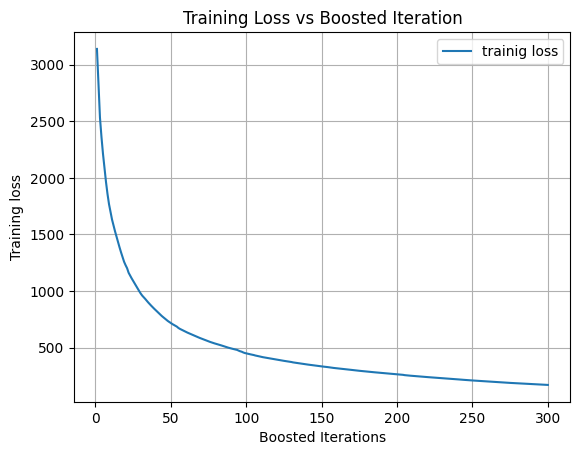

In [10]:
plt.plot(range(1,301),gisette_train_loss_300,label='trainig loss')
plt.xlabel('Boosted Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Boosted Iteration')
plt.grid()
plt.legend();

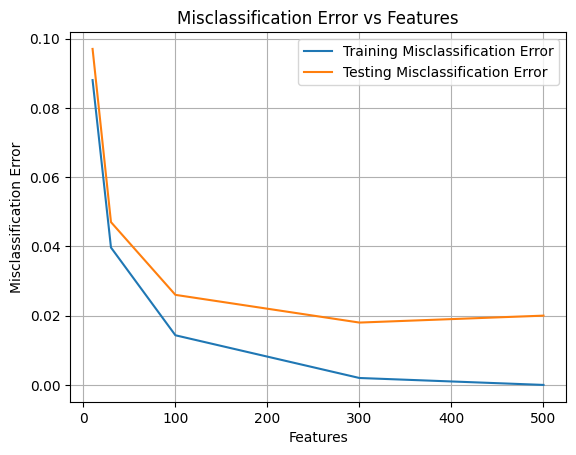

In [11]:
plt.plot(ks,gisette_misclassification_errors["train"],label='Training Misclassification Error')
plt.plot(ks,gisette_misclassification_errors["test"],label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [12]:
from IPython.display import HTML
d={'Features(K)':ks,'Training Error':gisette_misclassification_errors["train"],\
   'Testing Error':gisette_misclassification_errors["test"]}
HTML(pd.DataFrame(d).to_html(index=False))

Features(K),Training Error,Testing Error
10,0.088000,0.097
30,0.039667,0.047
100,0.014333,0.026
300,0.002000,0.018
500,0.000000,0.020


In [13]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(gisette_train_label, gisette_train_predictions)
test_fp, test_tp, _ = roc_curve(gisette_test_label, gisette_test_predictions)

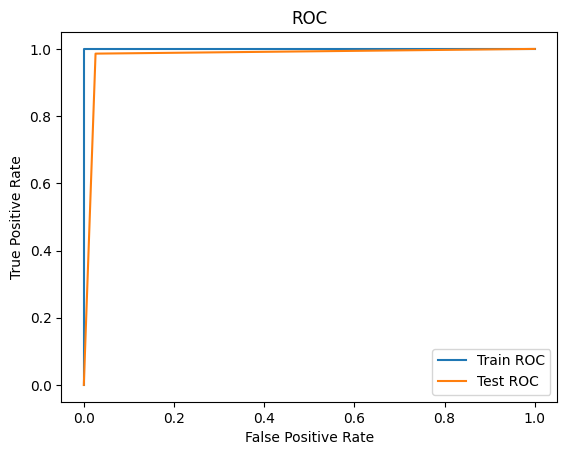

In [14]:
plt.plot(train_fp, train_tp, label='Train ROC')

plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [15]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(gisette_train_label, gisette_train_predictions)
auc_score_test = roc_auc_score(gisette_test_label, gisette_test_predictions)

In [16]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,1.00
Test,0.98


**b) Repeat point a) on the dexter dataset. (2 points)**

In [17]:
dexter_train_X_path = Path(r'D:/Pycharm/Courses/STA5635/HW6/dexter/dexter_train.csv')
dexter_train_label_path = Path(r'D:/Pycharm/Courses/STA5635/HW6/dexter/dexter_train.labels')
dexter_test_X_path = Path(r'D:/Pycharm/Courses/STA5635/HW6/dexter/dexter_valid.csv')
dexter_test_label_path = Path(r'D:/Pycharm/Courses/STA5635/HW6/dexter/dexter_valid.labels')

In [18]:
dexter_train_X = pd.read_csv(dexter_train_X_path, delimiter=',', header=None).values
dexter_train_label=np.ravel(pd.read_csv(dexter_train_label_path, delimiter=',', header=None).values)
dexter_test_X = pd.read_csv(dexter_test_X_path, delimiter=',', header=None).values
dexter_test_label=np.ravel(pd.read_csv(dexter_test_label_path, delimiter=',', header=None).values)

In [19]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(dexter_train_X,axis=0)
filt=sx>0
dexter_train_X=dexter_train_X[:,filt]
dexter_test_X=dexter_test_X[:,filt]
mx=np.mean(dexter_train_X,axis=0)
sx=np.std(dexter_train_X,axis=0)
dexter_train_X=(dexter_train_X-mx)/sx
dexter_test_X=(dexter_test_X-mx)/sx

In [20]:
dexter_train_X=np.c_[np.ones(dexter_train_X.shape[0]),dexter_train_X]
dexter_test_X=np.c_[np.ones(dexter_test_X.shape[0]),dexter_test_X]

In [21]:
dexter_misclassification_errors = {
    "train": [],
    "test": []
}

for k in ks:
    dexter_betas, l = logitboost(dexter_train_X, dexter_train_label, k)
    if k == 300:
        dexter_train_loss_300=l

    dexter_train_predictions = predictions(dexter_train_X, dexter_betas)
    dexter_test_predictions = predictions(dexter_test_X, dexter_betas)

    dexter_misclassification_errors["train"].append(misclassification_error(dexter_train_predictions,
                                                                             dexter_train_label))
    dexter_misclassification_errors["test"].append(misclassification_error(dexter_test_predictions,
                                                                            dexter_test_label))

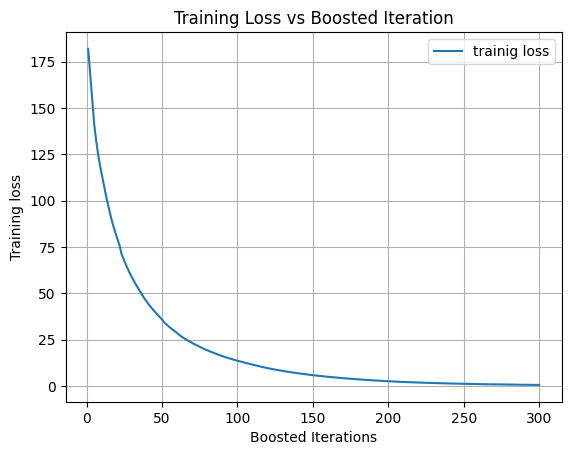

In [22]:
plt.plot(range(1,301),dexter_train_loss_300,label='trainig loss')
plt.xlabel('Boosted Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Boosted Iteration')
plt.grid()
plt.legend();

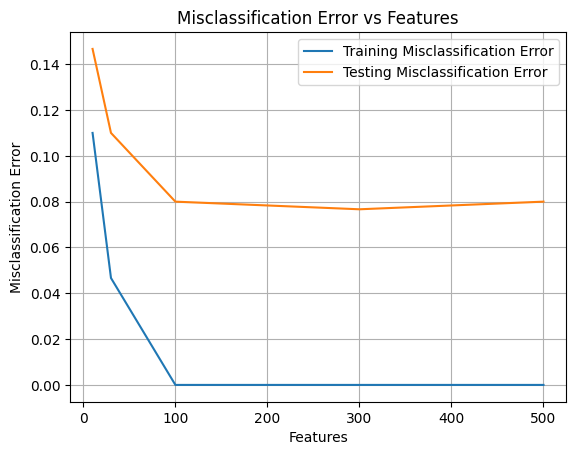

In [23]:
plt.plot(ks,dexter_misclassification_errors["train"],label='Training Misclassification Error')
plt.plot(ks,dexter_misclassification_errors["test"],label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [24]:
from IPython.display import HTML
d={'Features(K)':ks,'Training Error':dexter_misclassification_errors["train"],\
   'Testing Error':dexter_misclassification_errors["test"]}
HTML(pd.DataFrame(d).to_html(index=False))

Features(K),Training Error,Testing Error
10,0.110000,0.146667
30,0.046667,0.110000
100,0.000000,0.080000
300,0.000000,0.076667
500,0.000000,0.080000


In [25]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(dexter_train_label,  dexter_train_predictions)
test_fp, test_tp, _ = roc_curve(dexter_test_label,  dexter_test_predictions)

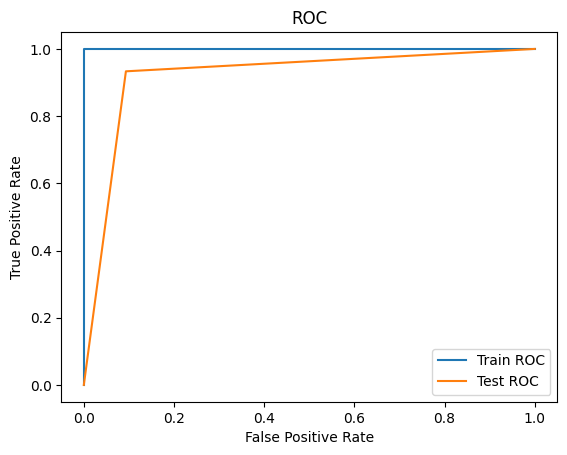

In [26]:
plt.plot(train_fp, train_tp, label='Train ROC')
plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [27]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(dexter_train_label,  dexter_train_predictions)
auc_score_test = roc_auc_score(dexter_test_label,  dexter_test_predictions)

In [28]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,1.00
Test,0.92


**c) Repeat point a) on the madelon dataset. (2 points)**

In [35]:
madelon_train_X_path = Path('D:\Pycharm\Courses\STA5635\HW6\MADELON\madelon_train.data')
madelon_train_label_path = Path('D:\Pycharm\Courses\STA5635\HW6\MADELON\madelon_train.labels')
madelon_test_X_path = Path('D:\Pycharm\Courses\STA5635\HW6\MADELON\madelon_valid.data')
madelon_test_label_path = Path('D:\Pycharm\Courses\STA5635\HW6\MADELON\madelon_valid.labels')

In [36]:
madelon_train_X = pd.read_csv(madelon_train_X_path, delimiter=' ', header=None).drop(500,axis=1).values
madelon_train_label = np.ravel(pd.read_csv(madelon_train_label_path, delimiter=' ', header=None).values)
madelon_test_X = pd.read_csv(madelon_test_X_path, delimiter=' ', header=None).drop(500,axis=1).values
madelon_test_label = np.ravel(pd.read_csv(madelon_test_label_path, delimiter=' ', header=None).values)

In [37]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(madelon_train_X,axis=0)
filt=sx>0
madelon_train_X=madelon_train_X[:,filt]
madelon_test_X=madelon_test_X[:,filt]
mx=np.mean(madelon_train_X,axis=0)
sx=np.std(madelon_train_X,axis=0)
madelon_train_X=(madelon_train_X-mx)/sx
madelon_test_X=(madelon_test_X-mx)/sx

In [ ]:
madelon_train_X=np.c_[np.ones(madelon_train_X.shape[0]),madelon_train_X]
madelon_test_X=np.c_[np.ones(madelon_test_X.shape[0]),madelon_test_X]

In [40]:
madelon_misclassification_errors = {
    "train": [],
    "test": []
}
for k in ks:
    madelon_betas, l = logitboost(madelon_train_X, madelon_train_label, k)
    if k == 300:
        madelon_train_loss_300=l

    madelon_train_predictions = predictions(madelon_train_X, madelon_betas)
    madelon_test_predictions = predictions(madelon_test_X, madelon_betas)

    madelon_misclassification_errors["train"].append(misclassification_error(madelon_train_predictions,
                                                                             madelon_train_label))
    madelon_misclassification_errors["test"].append(misclassification_error(madelon_test_predictions,
                                                                            madelon_test_label))

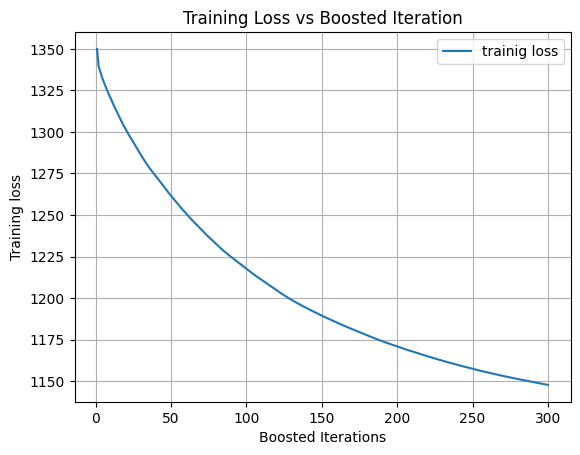

In [55]:
plt.plot(range(1,301),madelon_train_loss_300,label='trainig loss')
plt.xlabel('Boosted Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Boosted Iteration')
plt.grid()
plt.legend();

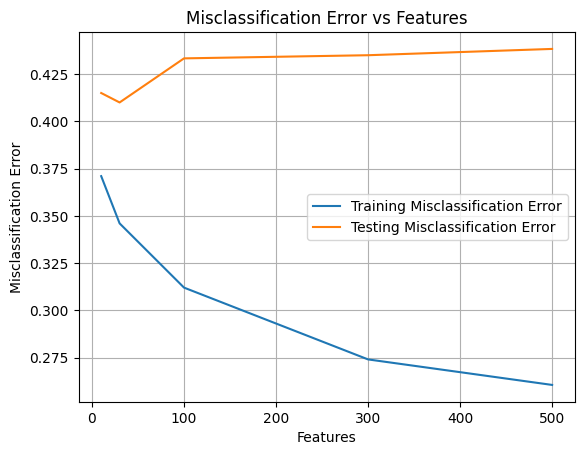

In [43]:
plt.plot(ks,madelon_misclassification_errors["train"],label='Training Misclassification Error')
plt.plot(ks,madelon_misclassification_errors["test"],label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [51]:
from IPython.display import HTML
d={'Features(K)':ks,'Training Error':madelon_misclassification_errors["train"],\
   'Testing Error':madelon_misclassification_errors["test"]}
HTML(pd.DataFrame(d).to_html(index=False))b

Features(K),Training Error,Testing Error
10,0.3710,0.415000
30,0.3460,0.410000
100,0.3120,0.433333
300,0.2740,0.435000
500,0.2605,0.438333


In [53]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(madelon_train_label, madelon_train_predictions)
test_fp, test_tp, _ = roc_curve(madelon_test_label, madelon_test_predictions)

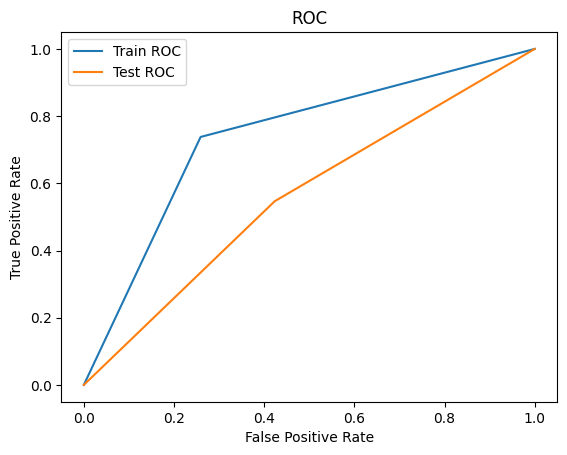

In [54]:
plt.plot(train_fp, train_tp, label='Train ROC')
plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [47]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(madelon_train_label, madelon_train_predictions)
auc_score_test = roc_auc_score(madelon_test_label, madelon_test_predictions)

In [48]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,0.739500
Test,0.561667
